In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
import tensorboard as tb
import tfanfis.anfis as anfis
import datetime
import tensorflow.keras.callbacks as callbacks
# sklearn classification report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2025-01-05 15:33:52.682703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 15:33:52.704648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 15:33:52.711050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 15:33:52.737568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 15:33:54.119335: W tensorflow/compiler/tf2

In [3]:
def accuracy_patient(df1, preds):
    preds_df = pd.merge(df1[['patient_id', 'sepsis_icd']], preds, on='patient_id')
    predictions = preds_df.groupby('patient_id').agg({'sepsis_icd': 'mean', 'preds': 'mean'})
    predictions['preds'] = np.where(predictions['preds'] >= 0.5, 1, 0)
    return predictions

In [4]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
def evaluate_metrics(y_true, preds, threshold=0.5):
    """
    Prints TPR, FPR, TNR, FNR, F1-score, and ROC-AUC values.
    
    Parameters:
    - y_true: Array-like, ground truth binary labels (0 or 1).
    - preds: Array-like, predicted probabilities or binary labels.
    - threshold: Threshold for converting probabilities to binary labels (default=0.5).
    """
    # If preds are probabilities, convert them to binary labels
    binary_preds = (preds >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, binary_preds).ravel()
    
    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
    f1 = f1_score(y_true, binary_preds)          # F1 Score
    roc_auc = roc_auc_score(y_true, preds)      # ROC AUC Score
    
    # Print results
    print("Classification Report")
    print(classification_report(y_true, binary_preds))
    print(f"TPR (True Positive Rate):  {tpr:.4f}")
    print(f"FPR (False Positive Rate): {fpr:.4f}")
    print(f"TNR (True Negative Rate):  {tnr:.4f}")
    print(f"FNR (False Negative Rate): {fnr:.4f}")
    print(f"F1-Score:                  {f1:.4f}")
    print(f"ROC-AUC:                   {roc_auc:.4f}")
    fpr, tpr, thresholds = roc_curve(y_true, preds)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [5]:
df = pd.read_csv('anfis_cleaned.csv')
print(df.shape)
df.head()

(35101, 15)


,heart_rate,bp_systolic,map,resp,temp,spo2,wbc,bun,creatinine,platelets,ph,bicarbonate,chloride,sepsis_icd,patient_id
0,81.0,91.0,57.0,20.0,36.890296,97.0,12.3,59.0,2.4,142.0,7.38,19.0,109.0,1.0,951
1,80.0,87.0,58.0,21.0,36.890296,100.0,12.3,59.0,2.4,142.0,7.38,19.0,109.0,1.0,951
2,80.0,80.0,48.0,16.0,36.666667,99.0,12.3,59.0,2.4,142.0,7.38,19.0,109.0,1.0,951
3,80.0,81.0,45.0,17.0,36.666667,96.0,12.3,59.0,2.4,142.0,7.38,19.0,109.0,1.0,951
4,80.0,86.0,49.0,17.0,36.666667,97.0,12.3,59.0,2.4,142.0,7.38,19.0,109.0,1.0,951


In [6]:
fis_df = pd.read_csv('fis_cleaned.csv')
print(fis_df.shape)
fis_df.head()

(11704, 15)


,heart_rate,bp_systolic,map,resp,temp,spo2,wbc,bun,creatinine,platelets,ph,bicarbonate,chloride,sepsis_icd,patient_id
0,87.0,115.0,62.0,18.0,36.722222,96.0,17.5,44.0,3.0,246.0,7.11,22.0,108.0,1.0,361
1,83.0,87.0,51.0,18.0,36.722222,96.0,17.5,44.0,3.0,246.0,7.11,22.0,108.0,1.0,361
2,75.0,70.0,45.0,16.0,36.722222,100.0,17.5,44.0,3.0,246.0,7.11,22.0,108.0,1.0,361
3,63.0,70.0,45.0,18.0,37.444444,100.0,17.5,44.0,3.0,246.0,7.11,22.0,108.0,1.0,361
4,84.0,90.0,63.0,18.0,37.444444,98.0,17.5,44.0,3.0,246.0,7.11,22.0,108.0,1.0,361


In [7]:
df.corrwith(df['sepsis_icd'])

heart_rate     0.207374
bp_systolic   -0.215339
map           -0.156394
resp           0.205679
temp          -0.007168
spo2          -0.051369
wbc            0.150312
bun            0.224342
creatinine     0.188726
platelets     -0.027369
ph            -0.229425
bicarbonate   -0.286298
chloride       0.083021
sepsis_icd     1.000000
patient_id    -0.000774
dtype: float64

In [8]:
df = df.drop(['temp', 'spo2', 'platelets', 'chloride'], axis=1)
fis_df = fis_df.drop(['temp', 'spo2', 'platelets', 'chloride'], axis=1)

In [9]:
df = df.iloc[:-29,:]
df.shape

(35072, 11)

In [10]:
X = df.drop('sepsis_icd', axis=1)
y = df['sepsis_icd']

In [11]:
X_features = X.drop(columns=['patient_id'])
scaler = StandardScaler()
X_features_sc = scaler.fit_transform(X_features)

In [12]:
fis_df = fis_df.iloc[:-24,:]
fis_df.shape

(11680, 11)

In [13]:
X_fis = fis_df.drop('sepsis_icd', axis=1)
y_fis = fis_df['sepsis_icd']
X_features_fis = X_fis.drop(columns=['patient_id'])
scaler = StandardScaler()
X_features_sc_fis = scaler.fit_transform(X_features_fis)

In [14]:
from catboost import CatBoostClassifier

In [ ]:
model_clf = CatBoostClassifier(iterations=1000,
                               depth=6,
                               task_type="GPU", verbose=10)
model_clf.fit(X_features, y)

Learning rate set to 0.006554
0:	learn: 0.6907616	total: 153ms	remaining: 12m 45s
10:	learn: 0.6670048	total: 1.19s	remaining: 8m 58s
20:	learn: 0.6457644	total: 2.21s	remaining: 8m 45s
30:	learn: 0.6271726	total: 3.33s	remaining: 8m 53s
40:	learn: 0.6111293	total: 4.48s	remaining: 9m 2s
50:	learn: 0.5968136	total: 5.49s	remaining: 8m 53s
60:	learn: 0.5838174	total: 6.54s	remaining: 8m 49s
70:	learn: 0.5719715	total: 7.56s	remaining: 8m 44s
80:	learn: 0.5612506	total: 8.6s	remaining: 8m 42s
90:	learn: 0.5516847	total: 9.6s	remaining: 8m 37s
100:	learn: 0.5428249	total: 10.7s	remaining: 8m 37s
110:	learn: 0.5344714	total: 11.7s	remaining: 8m 33s
120:	learn: 0.5264505	total: 12.7s	remaining: 8m 32s
130:	learn: 0.5194098	total: 13.7s	remaining: 8m 29s
140:	learn: 0.5128097	total: 14.7s	remaining: 8m 27s
150:	learn: 0.5069522	total: 15.8s	remaining: 8m 26s
160:	learn: 0.5006334	total: 16.8s	remaining: 8m 24s
170:	learn: 0.4945327	total: 17.8s	remaining: 8m 22s
180:	learn: 0.4895115	total: 

In [19]:
predicts = model_clf.predict(X_features_fis)

In [20]:
accuracy_score(y_fis, predicts)

0.7050513698630136

In [35]:
predicts = pd.DataFrame(predicts, columns=['preds'])
predicts['patient_id'] = fis_df['patient_id']
predicts_patient = accuracy_patient(fis_df, predicts)

accuracy_score(predicts_patient.sepsis_icd, predicts_patient.preds)

0.7074148296593187

Classification Report
              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71      5827
         1.0       0.72      0.67      0.69      5853

    accuracy                           0.71     11680
   macro avg       0.71      0.71      0.70     11680
weighted avg       0.71      0.71      0.70     11680

TPR (True Positive Rate):  0.6689
FPR (False Positive Rate): 0.2586
TNR (True Negative Rate):  0.7414
FNR (False Negative Rate): 0.3311
F1-Score:                  0.6945
ROC-AUC:                   0.7051


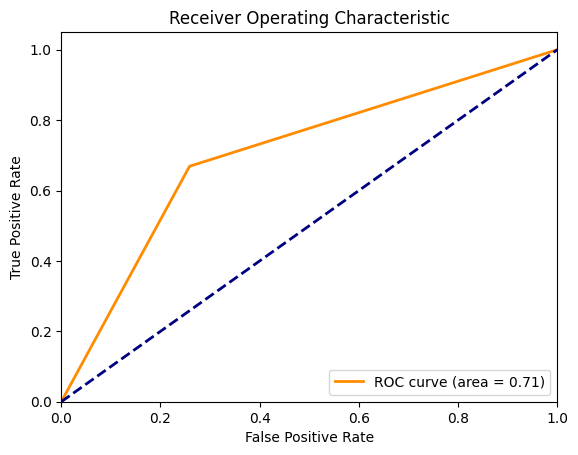

In [42]:
evaluate_metrics(fis_df.sepsis_icd ,predicts['preds'])

Classification Report
              precision    recall  f1-score   support

         0.0       0.69      0.75      0.72       249
         1.0       0.73      0.67      0.70       250

    accuracy                           0.71       499
   macro avg       0.71      0.71      0.71       499
weighted avg       0.71      0.71      0.71       499

TPR (True Positive Rate):  0.6680
FPR (False Positive Rate): 0.2530
TNR (True Negative Rate):  0.7470
FNR (False Negative Rate): 0.3320
F1-Score:                  0.6958
ROC-AUC:                   0.7075


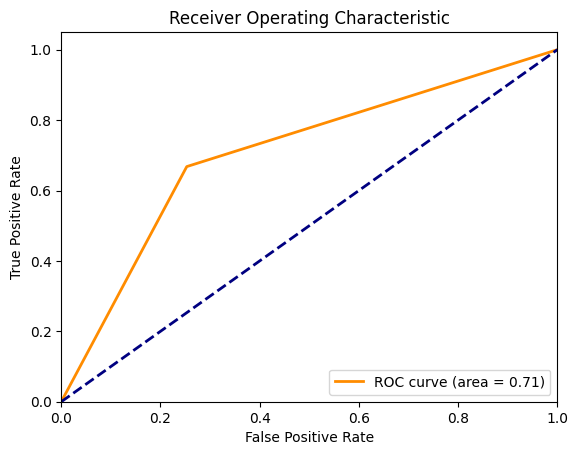

In [38]:
print('Classification Report with Grouped Patients')
evaluate_metrics(predicts_patient.sepsis_icd, predicts_patient.preds)

In [8]:
param = anfis.fis_parameters(
        n_input=X_features_sc.shape[1],
        n_memb=3,
        batch_size=32,
        memb_func='sigmoid',
        optimizer='adam',
        loss='mse',
        n_epochs=50
    )

In [9]:
fis = anfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis'
                    )

13


I0000 00:00:1735650669.925879   96251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735650670.360293   96251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735650670.360550   96251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735650670.369666   96251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735650670.369912   96251 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [10]:
fis.model.compile(optimizer=param.optimizer,
                    loss=param.loss
                    ,metrics=['mse']
                    )

In [11]:

logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

fis.fit(X_features_sc, y, epochs=param.n_epochs,
        callbacks=[tensorboard_callback])

Epoch 1/5


I0000 00:00:1735650674.800820   96369 service.cc:146] XLA service 0x7f7c00008730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735650674.801026   96369 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-31 16:11:14.868230: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-31 16:11:15.057140: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   1/1096 ━━━━━━━━━━━━━━━━━━━━ 1:45:29 6s/step - loss: 0.4495 - mse: 0.4495

I0000 00:00:1735650678.696186   96369 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.3031 - mse: 0.3031
Epoch 2/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.1494 - mse: 0.1494
Epoch 3/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.1250 - mse: 0.1250
Epoch 4/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.1080 - mse: 0.1080
Epoch 5/5
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.0910 - mse: 0.0910


In [22]:
%load_ext tensorboard

In [24]:
tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 119955), started 0:00:04 ago. (Use '!kill 119955' to kill it.)

In [14]:
preds = fis.predict(X_features_sc)
preds

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


array([[0.7756999 ],
       [0.8617102 ],
       [0.81828105],
       ...,
       [0.21475208],
       [0.195925  ],
       [0.17309996]], dtype=float32)

In [24]:
pd.DataFrame(preds).describe()

,0
count,35072.000000
mean,0.502007
std,0.389556
min,-0.512591
25%,0.146421
50%,0.459143
75%,0.880977
max,1.763477


In [28]:
# preds if preds > 0.5 else 0
preds[preds > 0.5] = 1
preds[preds <= 0.5] = 0

In [29]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     17538
         1.0       0.92      0.88      0.90     17534

    accuracy                           0.91     35072
   macro avg       0.91      0.91      0.91     35072
weighted avg       0.91      0.91      0.91     35072



In [21]:
confusion_matrix(y, preds.argmax(axis=1))

array([[17538,     0],
       [17534,     0]])

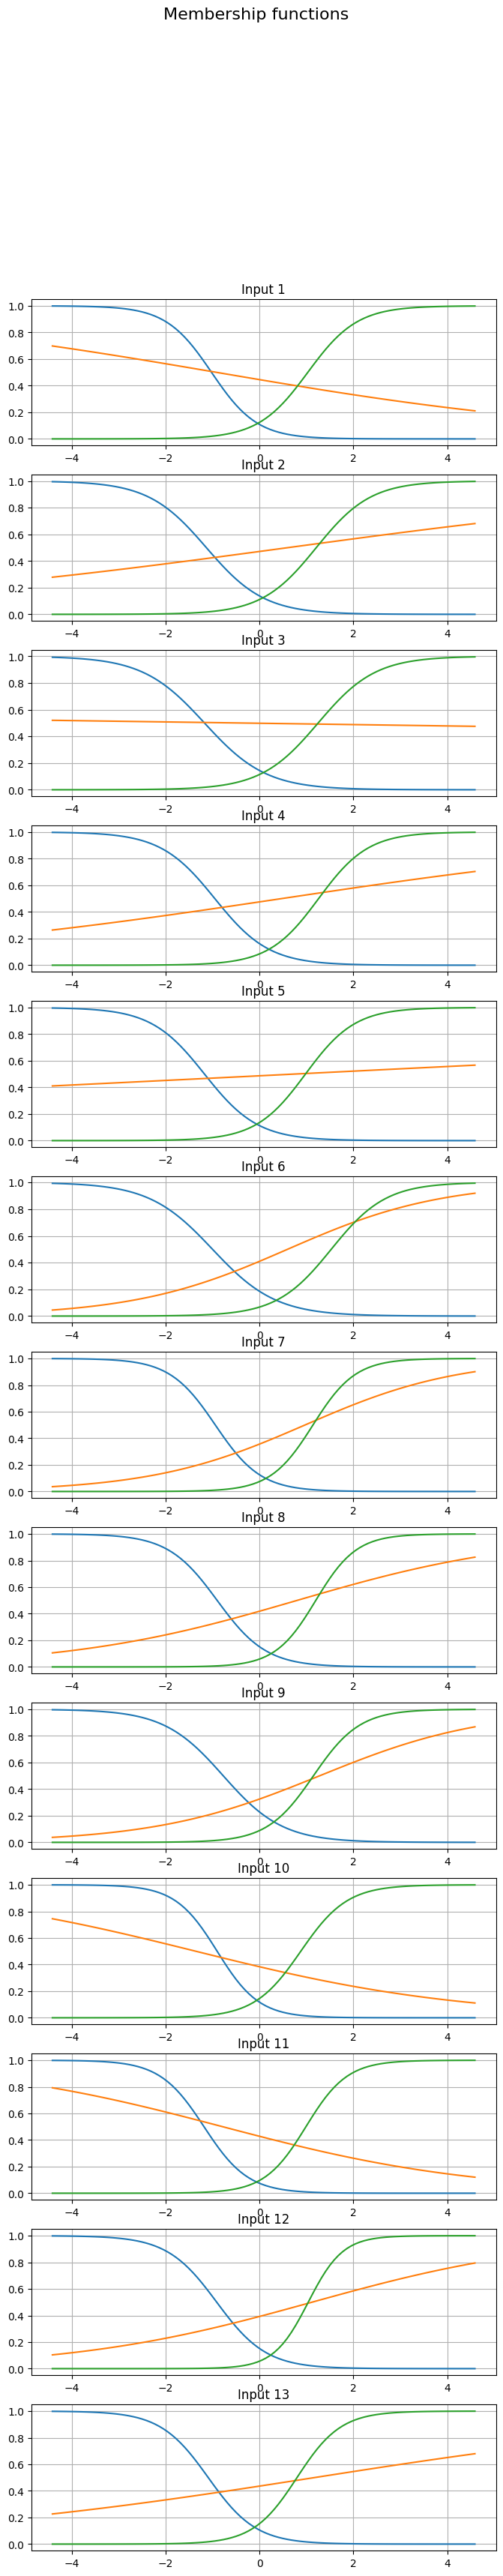

In [31]:
fis.plotmfs()

In [37]:
param = anfis.fis_parameters(
        n_input=X_features_sc.shape[1],
        n_memb=2,
        batch_size=32,
        memb_func='sigmoid',
        optimizer='adam',          # sgd / adam / ...
        # mse / mae / huber_loss / mean_absolute_percentage_error / ...
        loss='mae',
        n_epochs=50               # 10 / 25 / 50 / 100 / ...
    )
fis1 = anfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis1'
                    )
fis1.model.compile(optimizer=param.optimizer,
                    loss=param.loss
                    ,metrics=['mae']  # ['mae', 'mse']
                    )

13


In [38]:
fis1.model.summary()

Model: "myanfis1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputLayer          │ (32, 13)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzyLayer          │ (32, 2, 13)       │         52 │ inputLayer[0][0]  │
│ (FuzzyLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ruleLayer           │ (32, 8192)        │          0 │ fuzzyLayer[0][0]  │
│ (RuleLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normLayer           │ (32, 8192)        │          0 │ ruleLayer[0][0]   │
│ (NormLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defuzzLayer         │ (32, 8192)        │    114,688 │ normLayer[0][0],  │
│ (DefuzzLayer)       │                   │            │ inputLayer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sumLayer            │ (32, 1)           │          0 │ defuzzLayer[0][0] │
│ (SummationLayer)    │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,740 (448.20 KB)

 Trainable params: 114,740 (448.20 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

fis1.fit(X_features_sc, y, epochs=param.n_epochs,
        callbacks=[tensorboard_callback])

Epoch 1/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.5895 - mae: 0.5895
Epoch 2/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3891 - mae: 0.3891
Epoch 3/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3340 - mae: 0.3340
Epoch 4/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3041 - mae: 0.3041
Epoch 5/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2876 - mae: 0.2876
Epoch 6/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2756 - mae: 0.2756
Epoch 7/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2690 - mae: 0.2690
Epoch 8/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2598 - mae: 0.2598
Epoch 9/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2529 - mae: 0.2529
Epoch 10/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2489 - mae: 0.2489
Epoch 11/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2414 - mae: 0.2414
Epoch 12/50
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2357 - mae: 0.2357


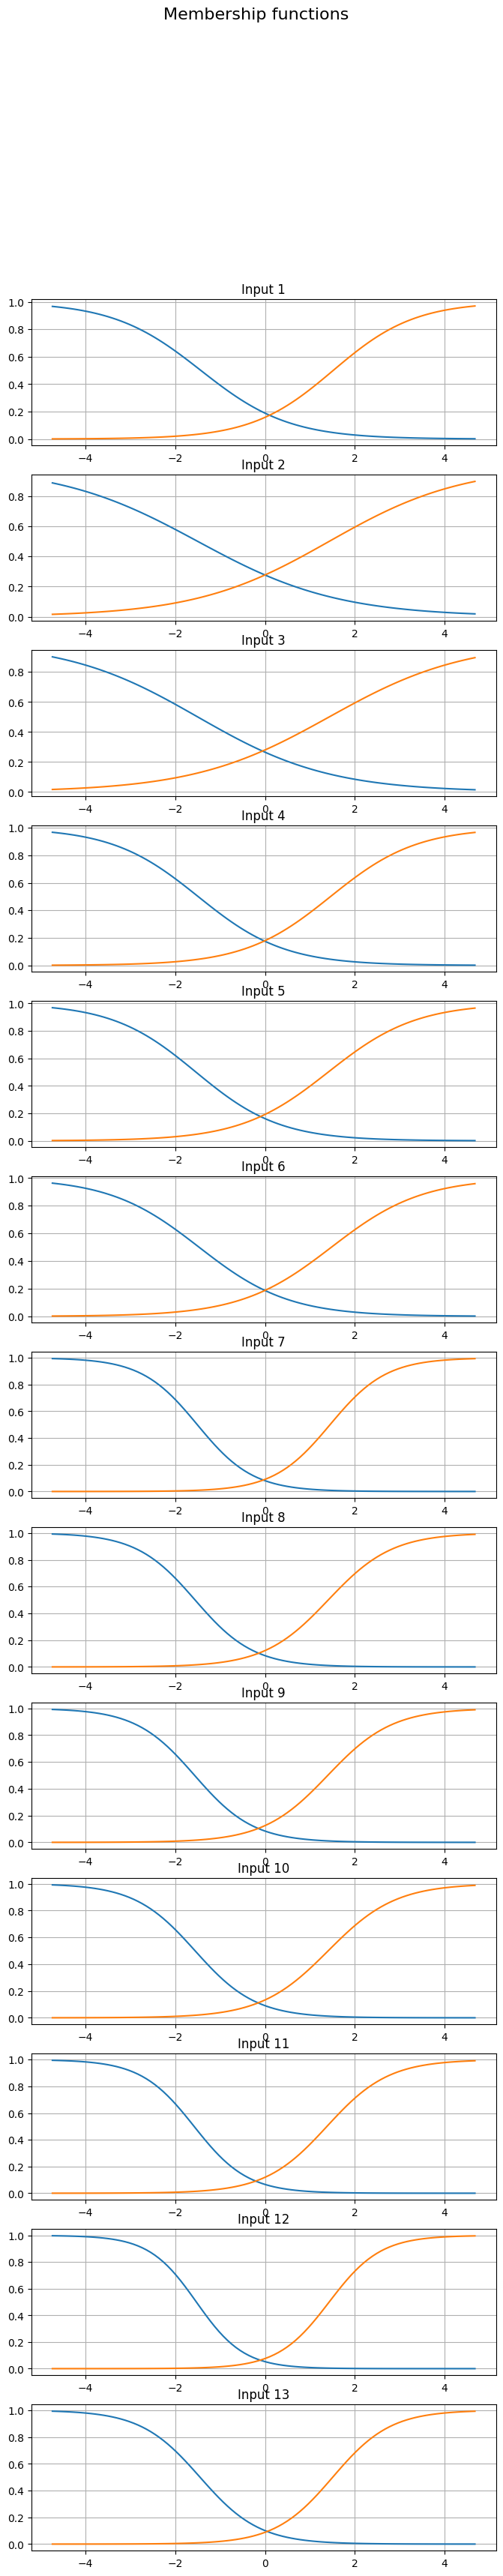

In [40]:
fis1.plotmfs()

In [41]:
preds1 = fis1.predict(X_features_sc)
preds1

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


array([[ 0.9879142 ],
       [ 1.0569367 ],
       [ 1.0105996 ],
       ...,
       [ 0.04835736],
       [-0.02928643],
       [ 0.13958912]], dtype=float32)

In [4]:
tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2012), started 0:03:11 ago. (Use '!kill 2012' to kill it.)

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True  # Use staircase decay for discrete drops in learning rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
param = anfis.fis_parameters(
        n_input=X_features_sc.shape[1],
        n_memb=2,
        batch_size=32,
        memb_func='sigmoid',
        optimizer=optimizer,
        loss='mae',
        n_epochs=200
    )
fis2 = anfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis1'
                    )
fis2.model.compile(optimizer=param.optimizer,
                    loss=param.loss
                    ,metrics=['mae']
                    )
fis2.model.summary()

13


Model: "myanfis1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputLayer          │ (32, 13)          │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzyLayer          │ (32, 2, 13)       │         52 │ inputLayer[0][0]  │
│ (FuzzyLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ruleLayer           │ (32, 8192)        │          0 │ fuzzyLayer[0][0]  │
│ (RuleLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normLayer           │ (32, 8192)        │          0 │ ruleLayer[0][0]   │
│ (NormLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defuzzLayer         │ (32, 8192)        │    114,688 │ normLayer[0][0],  │
│ (DefuzzLayer)       │                   │            │ inputLayer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sumLayer            │ (32, 1)           │          0 │ defuzzLayer[0][0] │
│ (SummationLayer)    │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,740 (448.20 KB)

 Trainable params: 114,740 (448.20 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

fis2.fit(X_features_sc, y, epochs=param.n_epochs,
        callbacks=[tensorboard_callback])

Epoch 1/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.4758 - mae: 0.4758
Epoch 2/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.2883 - mae: 0.2883
Epoch 3/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.2664 - mae: 0.2664
Epoch 4/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2508 - mae: 0.2508
Epoch 5/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2404 - mae: 0.2404
Epoch 6/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2280 - mae: 0.2280
Epoch 7/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2239 - mae: 0.2239
Epoch 8/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2177 - mae: 0.2177
Epoch 9/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.2106 - mae: 0.2106
Epoch 10/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2061 - mae: 0.2061
Epoch 11/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2016 - mae: 0.2016
Epoch 12/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.194

In [16]:
tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2012), started 0:33:59 ago. (Use '!kill 2012' to kill it.)

In [31]:
preds3 = fis2.predict(X_features_sc_fis)
# preds if preds > 0.5 else 0
preds3[preds3 > 0.5] = 1
preds3[preds3 <= 0.5] = 0
print(classification_report(y_fis, preds3))

365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.65      0.74      0.69      5827
         1.0       0.70      0.61      0.65      5853

    accuracy                           0.67     11680
   macro avg       0.68      0.67      0.67     11680
weighted avg       0.68      0.67      0.67     11680



In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True  # Use staircase decay for discrete drops in learning rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
param = anfis.fis_parameters(
        n_input=X_features_sc.shape[1],
        n_memb=2,
        batch_size=32,
        memb_func='sigmoid',
        optimizer=optimizer,
        loss='mae',
        n_epochs=200
    )
fis3 = anfis.ANFIS(n_input=param.n_input,
                    n_memb=param.n_memb,
                    batch_size=param.batch_size,
                    memb_func=param.memb_func,
                    name='myanfis1'
                    )
fis3.model.compile(optimizer=param.optimizer,
                    loss=param.loss
                    ,metrics=['mae']
                    )
fis3.model.summary()

I0000 00:00:1736081497.605545   91852 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736081497.961727   91852 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736081497.961996   91852 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736081497.971396   91852 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1736081497.971537   91852 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

9


Model: "myanfis1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputLayer          │ (32, 9)           │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fuzzyLayer          │ (32, 2, 9)        │         36 │ inputLayer[0][0]  │
│ (FuzzyLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ruleLayer           │ (32, 512)         │          0 │ fuzzyLayer[0][0]  │
│ (RuleLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normLayer           │ (32, 512)         │          0 │ ruleLayer[0][0]   │
│ (NormLayer)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defuzzLayer         │ (32, 512)         │      5,120 │ normLayer[0][0],  │
│ (DefuzzLayer)       │                   │            │ inputLayer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sumLayer            │ (32, 1)           │          0 │ defuzzLayer[0][0] │
│ (SummationLayer)    │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,156 (20.14 KB)

 Trainable params: 5,156 (20.14 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

fis3.fit(X_features_sc, y, epochs=param.n_epochs,
        callbacks=[tensorboard_callback])

Epoch 1/200


I0000 00:00:1736081525.432867   94658 service.cc:146] XLA service 0x7efce8005510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736081525.433293   94658 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-01-05 15:52:05.520156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-05 15:52:05.826927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   1/1096 ━━━━━━━━━━━━━━━━━━━━ 1:12:00 4s/step - loss: 0.9559 - mae: 0.9559

I0000 00:00:1736081528.237912   94658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.5619 - mae: 0.5619
Epoch 2/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3271 - mae: 0.3271
Epoch 3/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3099 - mae: 0.3099
Epoch 4/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.3041 - mae: 0.3041
Epoch 5/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3019 - mae: 0.3019
Epoch 6/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2982 - mae: 0.2982
Epoch 7/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2943 - mae: 0.2943
Epoch 8/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2942 - mae: 0.2942
Epoch 9/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2914 - mae: 0.2914
Epoch 10/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2899 - mae: 0.2899
Epoch 11/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2891 - mae: 0.2891
Epoch 12/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2826 - mae: 0.2826
E

In [20]:
preds4 = fis3.predict(X_features_sc_fis)
# preds if preds > 0.5 else 0
preds4[preds4 > 0.5] = 1
preds4[preds4 <= 0.5] = 0
print(classification_report(y_fis, preds4))

365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.72      5827
         1.0       0.73      0.65      0.68      5853

    accuracy                           0.70     11680
   macro avg       0.70      0.70      0.70     11680
weighted avg       0.70      0.70      0.70     11680



Classification Report
              precision    recall  f1-score   support

         0.0       0.68      0.75      0.72      5827
         1.0       0.73      0.65      0.68      5853

    accuracy                           0.70     11680
   macro avg       0.70      0.70      0.70     11680
weighted avg       0.70      0.70      0.70     11680

TPR (True Positive Rate):  0.6460
FPR (False Positive Rate): 0.2454
TNR (True Negative Rate):  0.7546
FNR (False Negative Rate): 0.3540
F1-Score:                  0.6835
ROC-AUC:                   0.7003


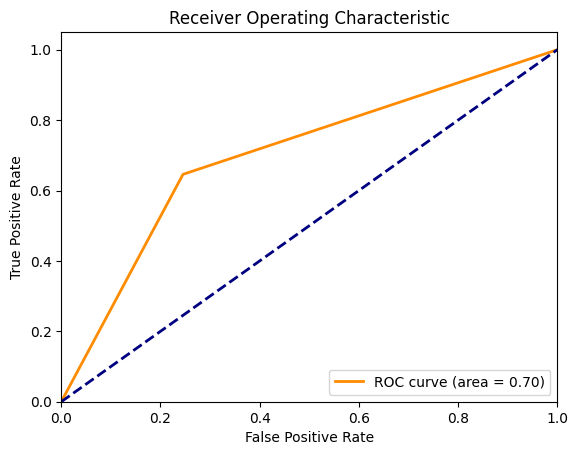

In [21]:
evaluate_metrics(y_fis, preds4)